<a href="https://colab.research.google.com/github/chatterjee-srinjoy/MachineLearning/blob/main/BME_6120_machine_learning_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BME6120 Machine Learning Workshop**
---



In this workshop we'll be exploring the use of machine learning for biomarker identification in disease diagnostics. Specifically, we will be analyzing RNA sequencing data from plasma cell-free RNA collected from patients that are TB negative or TB positive. We'll be using R packages to perform essential ML tasks from feature selection, dataset splitting and model training. We'll be loosely following the workflow from this [2024 paper](https://www.nature.com/articles/s41467-024-49245-6#code-availability).

Please submit a pdf of your worksheet to Gradescope and your Colab notebook to id93@cornell.edu and hxz2@cornell.edu


### 🛑 **IMPORTANT: Please follow these steps before proceeding:**

1. Save a local copy of this notebook by selecting **File > Save a copy in Drive**. If you are prompted to trust the notebook, please proceed—it is safe.

2. Remember: **Run the code in this notebook in sequential order**



# 💾 Installing packages

In [ ]:
#@title Run this code only if you were unable to pre-install the packages.

#uncomment everything if you are going to run it
#Install packages available in CRAN

#install.packages("binom")
#install.packages("reshape2")
#install.packages("caret")
#install.packages("ggrepel")
#install.packages("ggvenn")
#install.packages("gplots")
#install.packages("pheatmap")
#install.packages("polycor")
#install.packages("pROC")
#install.packages("qualpalr")
#install.packages("eulerr")

#Install Bioconductor and related packages

#install.packages("BiocManager", repos="https://cloud.r-project.org/")
#BiocManager::install("DESeq2", ask = FALSE)
#BiocManager::install("genefilter", ask = FALSE)


In [ ]:
#downloads the package folder and extracts it. Please install packages through the block above if you are unable to get this to work
#replace the link below with your own
url <- "https://drive.usercontent.google.com/download?id=1PdTXbBZq9_-uCjktJrVea-aIPZA_HpJP&export=download&authuser=1&confirm=t&uuid=e7acbf4c-5a90-4a18-8451-b91ebee25ec7&at=ALWLOp4EjPbeFpqBqYelI4iR_DCt:1763949717612"
download.file(url, destfile="library.tar.gz")
untar("library.tar.gz", exdir="library")
#flattens the folder
system("mv library/library/* library/")
#changes R library directory
.libPaths("library")

In [ ]:
#load the packages
suppressMessages(library(tidyverse))
suppressMessages(library(magrittr))
suppressMessages(library(genefilter))
suppressMessages(library(DESeq2))
suppressMessages(library(readr))
suppressMessages(library(data.table))
suppressMessages(library(matrixStats))
suppressMessages(library(pheatmap))
suppressMessages(library(gplots))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ggrepel))
suppressMessages(library(reshape2))
suppressMessages(library(dplyr))
suppressMessages(library(qualpalr))
suppressMessages(library(caret))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(reshape2))
suppressMessages(library(pROC))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))
suppressMessages(library(binom))
suppressMessages(library(polycor))
options(stringsAsFactors = FALSE)

# 📂 Download experimental data

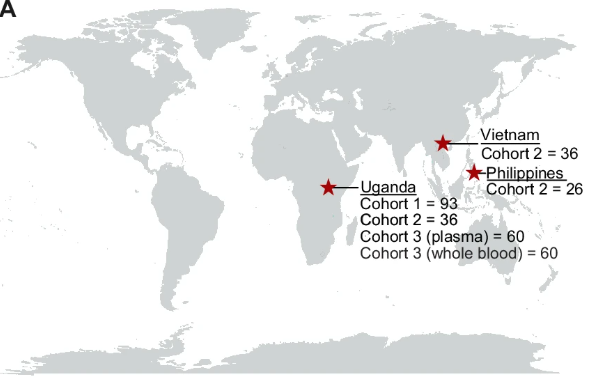

In [ ]:
# clone github repository and set it as the working directory
system("git clone https://github.com/DanielEweisLaBolle/cfRNA_TB.git /content/cfRNA_TB")
setwd("/content/cfRNA_TB")

#Read in the count matrices
counts_train = read.delim("Files_For_Manuscript/counts.train.tsv",row.names=1)
counts_test = read.delim("Files_For_Manuscript/counts.test.tsv", row.names = 1)
counts_val = read.delim("Files_For_Manuscript/counts.val.tsv",row.names=1)

#Read in the metadata
metadata_train = read.delim("Files_For_Manuscript/metadata.train.tsv")
metadata_test = read.delim("Files_For_Manuscript/metadata.test.tsv")
metadata_val =  read.delim("Files_For_Manuscript/metadata.val.tsv")

#Read in other files
decon = read.delim("Files_For_Manuscript/discovery_cell_types.tsv")
gene.list = read.delim("Files_For_Manuscript/gencode.biotype.name.key.tsv")

#This file contains some of the functions that we will be calling
source("Files_For_Manuscript/DAA_scripts.R")

# Differential gene expression :



## Prepare all of the data for DESeq2

In [ ]:
#Concatenate Metadata
metadata_concat = rbind(metadata_train, metadata_test, metadata_val)
#Recode site to match the country it was collected from across cohorts
metadata_concat <- metadata_concat %>%
  mutate(site = recode(site,
                       "Kisenyi" = "Uganda",
                       "Mulago" = "Uganda"))
metadata_concat <- metadata_concat %>%
  mutate(site = ifelse(is.na(site) | site == "", "Uganda", site))

#Assign variables for differential abundance analysis
SAMPLE_ID_VAR = "sample_id"
COMP_VAR = "tb"
GROUPS = c("positive","negative")

gene_name_key = "Files_For_Manuscript/gencode.biotype.name.key.tsv"

DESIGN = paste0("~",COMP_VAR)

#Concatenate count matrices
counts <- cbind(counts_train, counts_test, counts_val)
samples <- metadata_concat %>%
     filter(.data[[COMP_VAR]] %in% GROUPS)
rownames(samples) <- samples$sample_id
counts <- counts[, rownames(samples)]

## DESeq2

In [ ]:
##------------------------------------
# Construct DESeq Data Set
dds <- DESeqDataSetFromMatrix(counts,
                                colData = samples,
                                design = formula(DESIGN))

##------------------------------------
# Add Gene metadata
annotation = fread(file=gene_name_key)
annotation <- annotation[match(rownames(dds), annotation$gene_id),]
all(rownames(dds) == annotation$ftcount_id)
mcols(dds) <- cbind(mcols(dds), annotation)

##------------------------------------
# Re-factor
dds[[COMP_VAR]] <- factor(dds[[COMP_VAR]], levels = GROUPS)

##------------------------------------
# DAA for all 251 TB samples
dds <- DESeq(dds)

In [ ]:
# output a summary of results
res <- results(dds,alpha=0.05,contrast = c(COMP_VAR,GROUPS[1], GROUPS[2]))

res$gene_name <- mcols(dds)$gene_name
res$gene_type <- mcols(dds)$gene_type

summary(res)

## Heatmap of DEGs

In [ ]:
#Heatmap of differentially expressed genes (p<0.05)
options(repr.plot.width=15,repr.plot.height=7)
mycolors <- list(
   tb = c("positive" = "#ff70a6",
                 "negative" = "#2E294E"),
    hiv = c("Positive"= "#f77f00",
                   "Negative" = "#8F2D56"),
    cohort = c("GHL" = "#73D2DE",
               "R2D2" = "#b5179e",
               "TBSQUARE"="gold"),
    site = c("Uganda" = "#218380",
                "Vietnam" = "#FFBC42",
                "Philippines" = "#D81159"))

vars = c("tb", "hiv", "cohort", "site")

options(repr.plot.width=7,repr.plot.height=7)

# Set layout: 2 side-by-side panels
layout(matrix(c(1,2), nrow=1), widths=c(3,1))

# LEFT PANEL
# Keep margins small for heatmap
par(mar=c(4,4,2,1))

# This will draw directly to the left panel
htmap <- make_heatmap(
    res, counts, samples, "sample_id",
    mycolors, vars,
    SIG_THRESH = 0.05, FC_THRESH = 0
)

#RIGHT PANEL
par(mar=c(2,2,2,2))
plot.new()

# Custom helper with bigger text
draw_cat_legend <- function(title, colors, x, y, text_cex = 1.3, title_cex = 1.5) {
    legend(
        x = x, y = y,
        legend = names(colors),
        fill = colors,
        bty = "n",
        title = title,
        cex = text_cex,
        pt.cex = 2.0,
        title.cex = title_cex,
        xpd = NA     # prevents cutoff at edge
    )
}

# Horizontal spacing (4 equal positions)
draw_cat_legend("TB",     mycolors$tb,     x=-0.15, y=1.00)
draw_cat_legend("HIV",    mycolors$hiv,    x=0.30, y=1.00)
draw_cat_legend("Cohort", mycolors$cohort, x=0.75, y=1.00)
draw_cat_legend("Site",   mycolors$site,   x=1.20, y=1.00)

# Z-score gradient centered underneath all 4 legends

par(fig = c(0.2, 0.8, 0.55, 0.75), new=TRUE)
zcols <- colorRampPalette(c("blue","yellow"))(100)

image(
    z = matrix(seq(-2, 2, length=100), ncol=1),
    col = zcols,
    axes = FALSE
)

axis(1, at=c(0,1), labels=c("-2","2"), cex.axis=1.2)
mtext("z-score", side=3, line=0.3, cex=1.3)

## Upregulated pathways

In [ ]:
# Read in the IPA output file
canonical_path = read.table("Files_For_Manuscript/ipa_output.txt" , sep="\t", header=T)

# Quantify the number of molecules in each identified pathway
canonical_path$mol_num= unlist(lapply(unlist(canonical_path$Molecules), function(x){length(unlist(strsplit( x, ",")))}))

p = canonical_path %>%
    # Set cutoffs for Z-score, p-value, and molecule number
    filter(abs(X.log.p.value.) > 1) %>%
    filter(abs(z.score) > 2.55) %>%
    filter(mol_num > 6) %>%
    # Plot
    ggplot(aes(x = reorder(Ingenuity.Canonical.Pathways, abs(z.score)), y = abs(z.score), fill = ifelse(z.score < 0, "#D81159", "#218380"))) +
    geom_bar(stat = 'identity') +
    geom_text(aes(label = Ingenuity.Canonical.Pathways, y = abs(z.score) + 0.06), hjust = 0, color = "black", size = 6.5) +
    geom_blank(aes(y = max(abs(z.score)) * 4)) +  # Invisible layer to extend plot area
    coord_flip(clip =  "off") +
    theme_bw(base_size = 8) +
    theme(
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 20),
        axis.line.x = element_line(color = "black", size = 0.5),
        legend.key.size = unit(0.25, 'cm'),
        legend.title = element_text(size = 5),
        legend.text = element_text(size = 4),
        legend.position = "none",
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        plot.margin = margin(5.5, 250, 5.5, 5.5)
    ) +
    ylab("z-score")

p


# Preparing the data for machine learning ⌨



In [ ]:
#@title Run this code to skip past differential gene expression
#Concatenate Metadata
metadata_concat = rbind(metadata_train, metadata_test, metadata_val)
#Recode site to match the country it was collected from across cohorts
metadata_concat <- metadata_concat %>%
  mutate(site = recode(site,
                       "Kisenyi" = "Uganda",
                       "Mulago" = "Uganda"))
metadata_concat <- metadata_concat %>%
  mutate(site = ifelse(is.na(site) | site == "", "Uganda", site))

#Assign variables for differential abundance analysis
SAMPLE_ID_VAR = "sample_id"
COMP_VAR = "tb"
GROUPS = c("positive","negative")

gene_name_key = "Files_For_Manuscript/gencode.biotype.name.key.tsv"

DESIGN = paste0("~",COMP_VAR)

#Concatenate count matrices
counts <- cbind(counts_train, counts_test, counts_val)
samples <- metadata_concat %>%
     filter(.data[[COMP_VAR]] %in% GROUPS)
rownames(samples) <- samples$sample_id
counts <- counts[, rownames(samples)]

## Splitting the dataset

In [ ]:
set.seed(2)

#Splitting our dataset into validation dataset and discovery dataset
# Extract the first column of metadata which contains the cohort information
sample_ids <- metadata_concat[[1]]

#Identify cohort groups
is_cohort3    <- grepl("^TBSQUARE", sample_ids)
is_cohort12 <- grepl("^(GHL|R2D2)", sample_ids)

#split the metadata into validation and discovery datasets based on cohort
metadata_val  <- metadata_concat[is_cohort3, ]
metadata_discovery <- metadata_concat[is_cohort12, ]

#split counts matrix based on matched sample IDs
counts_val  <- counts[, is_cohort3, drop = FALSE]
counts_discovery <- counts[, is_cohort12, drop = FALSE]

In [ ]:
#Splitting our discovery dataset into training and test sets
md <- metadata_discovery

#Extract cohort identity from first column
md$CohortSimple <- ifelse(
    grepl("^GHL",  md$sample_id), "GHL",
    ifelse(grepl("^R2D2", md$sample_id), "R2D2", NA)
)

#Create a stratification label based on cohort, HIV status and TB outcome
#Note that column
md$strata <- with(md, interaction(md$CohortSimple, md[[2]], md[[3]], drop = TRUE))

#create a 70/30 split
train_idx <- createDataPartition(md$strata, p = 0.7, list = FALSE)

metadata_train <- md[train_idx, ]
metadata_test  <- md[-train_idx, ]

#split count matrix based on metadata split
counts_train <- counts_discovery[, metadata_train[[1]], drop = FALSE]
counts_test  <- counts_discovery[, metadata_test[[1]], drop = FALSE]

## DESeq2 for feature selection


In [ ]:
## Prepare data for Deseq2
meta_col = metadata_train
disc_cts = counts_train
#Subset Columns
meta_col = meta_col %>% select("sample_id", "tb")
rownames(meta_col) = meta_col$sample_id
#Check for alignment
all(colnames(disc_cts) == rownames(meta_col))


## run Deseq2 & extract results
dds <- DESeqDataSetFromMatrix(countData = disc_cts,
                             colData = meta_col,
                             design = ~ tb)
dds <- DESeq(dds)
res <- results(dds)

## Extract results
res_df = results(dds,alpha=0.05,contrast = c("tb","positive", "negative")) %>% data.frame()
#Get the Gene ID's as a column
res_df$gene_num = rownames(res_df)
#Merge with out labeled gene list to acquire gene names and info
res_df = merge(res_df, gene.list, by.x = "gene_num", by.y = "gene_id")
#Signifcant genes using padj<0.05 and baseMean>100. These will be the features that we train our model(s) on
sigs = res_df %>% arrange(padj) %>% filter(padj < 0.05) %>% filter(baseMean > 100)

print(paste(nrow(sigs), "genes are significantly expressed and were selected as features for training"))

[1] TRUE

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 345 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "229 genes are significantly expressed and were selected for training"


## Normalizing and wrangling the data

In [ ]:
##Normalize via VST

counts_train_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_train)) %>% data.frame()
counts_test_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_test)) %>% data.frame()
counts_val_norm <- DESeq2::varianceStabilizingTransformation(as.matrix(counts_val)) %>% data.frame()

#------------------------------------------------
## Wrangle data into Plot Friendly Format
#------------------------------------------------

#Train data
norm_plot_dat_train = counts_train_norm %>%
    as.data.frame() %>%
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_train = merge(norm_plot_dat_train, metadata_train, by.x = "sample_id")

#Test data
norm_plot_dat_test = counts_test_norm %>%
    as.data.frame() %>%
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_test = merge(norm_plot_dat_test, metadata_test, by.x = "sample_id")

#Validation data
norm_plot_dat_val = counts_val_norm %>%
    as.data.frame() %>%
    tibble::rownames_to_column(., var = "gene_id") %>%
    gather(sample_id, value, -gene_id) %>%
    spread(gene_id, value)

norm_plot_dat_val = merge(norm_plot_dat_val, metadata_val, by.x = "sample_id")

# Remove 'CohortSimple' and 'strata' columns from train and test data to match validation data
norm_plot_dat_train <- norm_plot_dat_train %>% select(-CohortSimple, -strata)
norm_plot_dat_test <- norm_plot_dat_test %>% select(-CohortSimple, -strata)

#Merge all for later plots
norm_plot_dat_all = rbind(norm_plot_dat_train, norm_plot_dat_test, norm_plot_dat_val)

# Training and evaluating machine learning models :

## Generalized linear models

In [ ]:
### TRAINING SET GLM ###
df = norm_plot_dat_train
#Prepare metadata (tb as factor)
df$tb <- ifelse(df$tb == "positive",1,0)
df$tb <- as.factor(df$tb)

# Correctly extract gene IDs from sigs dataframe
sig_genes_raw <- as.character(sigs$gene_num)

# Ensure that only genes present in df are used in the formula
available_genes_in_df <- colnames(df)
sig_genes <- intersect(sig_genes_raw, available_genes_in_df)

#construct the formula (tells the model what features to use to predict which label)
formula <- as.formula(paste("tb ~", paste(sig_genes, collapse = "+"), "- 1"))

#create the GLM model
model_train <- glm(formula, data = df, family = "binomial")
#Calculate predictions on training set
probs <- predict(model_train, newdata = df, type = "response")
# Calculate ROC and AUC
roc_train <- roc(df$tb, probs)
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))
# Calculate the Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1
# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]
# Print the AUC value
print(paste0("Training ROC-AUC: ", round(auc(roc_train),3)))
print(paste0("Training ROC-AUC 95% CI: [", round(roc_train_ci[1],3), "--", round(roc_train_ci[3],3), "]"))
# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)
# Create Confusion matrix
conf_matrix_train <- table(df$tb, df$predicted)
# True positive
tp_train <- conf_matrix_train[2, 2]
# True Negative
tn_train <- conf_matrix_train[1, 1]
# Calculate the Accuracy
accuracy_train <- (tp_train + tn_train) / sum(conf_matrix_train)
print(paste("Train Accuracy: ", round(accuracy_train, 3)))

# Calculate the Sensitivity
sensitivity_train <- tp_train / (tp_train + conf_matrix_train[2, 1])
# Calculate the Specificity
specificity_train <- tn_train / (tn_train + conf_matrix_train[1, 2])

### 95% CI for Sensitivity and Specificity ###
# Set z-score for a two tailed 95% confidence test
z <- qnorm(0.975)

# Calculate the number of true positives and true negatives
n_tp <- tp_train + conf_matrix_train[2, 1]  # TP + FN
n_tn <- tn_train + conf_matrix_train[1, 2]  # TN + FP

# Calculate the standard error for sensitivity and specificity
se_sensitivity <- sqrt(sensitivity_train * (1 - sensitivity_train) / n_tp)
se_specificity <- sqrt(specificity_train * (1 - specificity_train) / n_tn)

# Calculate 95% CI for sensitivity
ci_lower_sensitivity <- sensitivity_train - z * se_sensitivity
ci_upper_sensitivity <- sensitivity_train + z * se_sensitivity

# Calculate 95% CI for specificity
ci_lower_specificity <- specificity_train - z * se_specificity
ci_upper_specificity <- specificity_train + z * se_specificity

# Print 95% CI
print(paste("Train Sensitivity: ", round(sensitivity_train, 3)))
print(paste("Train Sensitivity:  95% CI: [", round(ci_lower_sensitivity, 3), ",", round(ci_upper_sensitivity, 4), "]"))
print(paste("Train Specificity: ", round(specificity_train, 3)))
print(paste("Train Specificity:  95% CI: [", round(ci_lower_specificity, 3), ",", round(ci_upper_specificity, 4), "]"))

Warning message:
“glm.fit: algorithm did not converge”
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Warning message in ci.auc.roc(roc_train):
“ci.auc() of a ROC curve with AUC == 1 is always 1-1 and can be misleading.”


[1] "Training ROC-AUC: 1"
[1] "Training ROC-AUC 95% CI: [1--1]"
[1] "Train Accuracy:  1"
[1] "Train Sensitivity:  1"
[1] "Train Sensitivity:  95% CI: [ 1 , 1 ]"
[1] "Train Specificity:  1"
[1] "Train Specificity:  95% CI: [ 1 , 1 ]"


In [ ]:
### TEST SET GLM###
df = norm_plot_dat_test
#Prepare metadata (tb as factor)
df$tb <- ifelse(df$tb == "positive",1,0)
df$tb <- as.factor(df$tb)
# Calculate predictions
probs <- predict(model_train, newdata = df, type = "response")
# Calculate ROC and AUC
roc_test <- roc(df$tb, probs)
roc_test_ci = ci.auc(roc_test)
print(paste0("Test ROC-AUC: ",round(auc(roc_test),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_test_ci[1],3), "--", round(roc_test_ci[3],3), "]"))
# Assign labels using optimal threshold
df$predicted <- ifelse(probs > optimal$threshold, 1, 0)
# Create Confusion matrix
conf_matrix <- table(df$tb, df$predicted)
# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Test Accuracy: ", round(accuracy_test, 3)))
# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Test", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Test Sensitivity: ",
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Test", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Test Specificity: ",
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.522"
[1] "Test ROC-AUC 95% CI: [0.38--0.664]"
[1] "Test Accuracy:  0.537"
[1] "Test Sensitivity:  0.533"
[1] "Test Sensitivity:  95% CI: [ 0.361 , 0.698 ]"
[1] "Test Specificity:  0.542"
[1] "Test Specificity:  95% CI: [ 0.351 , 0.721 ]"


## Plot the ROCs (GLM)

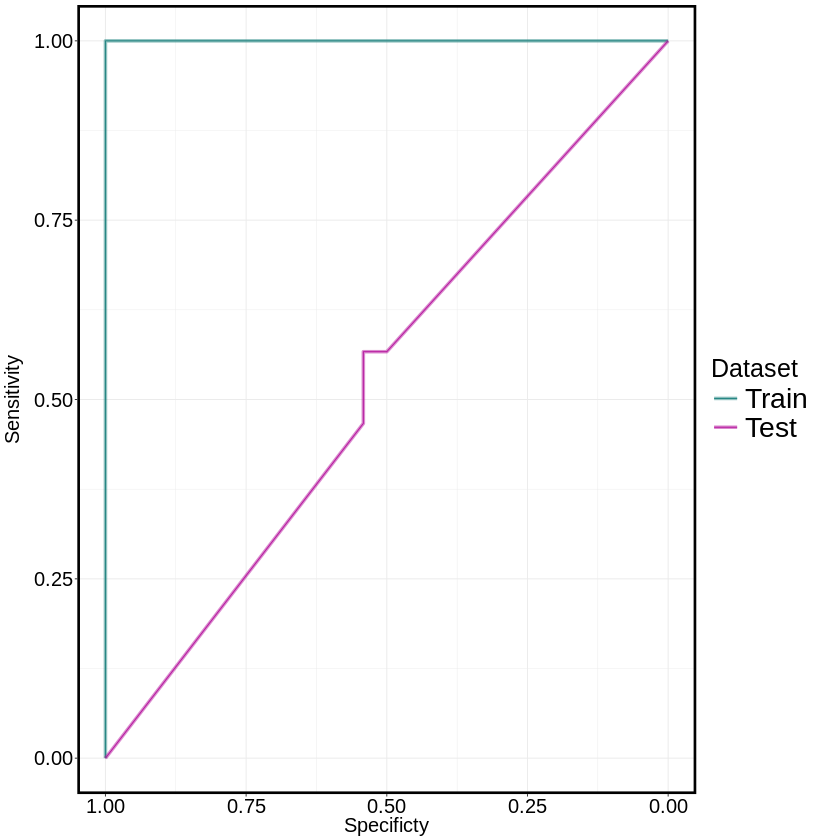

In [ ]:
p = ggroc(list("Train"= roc_train, "Test" = roc_test), aes=c("color"))  +
    theme_bw(base_size=6) +
    geom_line(size=1,alpha=0.5) +
    scale_color_manual(values=c("#218380","#B5179E"), name = "Dataset") +
    xlab("Specificty") + ylab("Sensitivity") +
    theme(axis.text=element_text(size=12, color="black"),
          axis.title=element_text(size=12, color="black"),
          panel.border = element_rect(size = 1.5, color ="black"),
          legend.text = element_text(size = 17),  # Increase legend text size
          legend.title = element_text(size = 15)) # Increase legend title size
p

## Lasso Regularization

In [ ]:
#install and load glmnet package, oops again!
install.packages("glmnet")
suppressMessages(library(glmnet))

Installing package into ‘/content/library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




Lasso Regularization plus K-fold cross-validation and hyperparameter tuning

In [ ]:
set.seed(2)
#load in training dataset
df = norm_plot_dat_train

# Convert TB status: positive = 1, other = 0
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

# Extract significant genes
sig_genes_raw <- as.character(sigs$gene_num)

# Use only genes actually in df
available_genes <- colnames(df)
sig_genes <- intersect(sig_genes_raw, available_genes)

# Final dataset for modeling (TB + predictors)
df_model <- df[, c("tb", sig_genes)]

# caret expects factor levels as characters "Negative" and "Positive"
df_model$tb <- factor(df_model$tb, levels = c("0","1"), labels = c("Negative", "Positive"))

# Define the tuneGrid with alpha=1 for Lasso
tune_grid_lasso = expand.grid(
    alpha = 1, # Lasso regularization
    lambda = seq(0.0001, 1, length = 50) # Range of lambda values. #CHANGE the LENGTH
)

# Define trainControl for k-fold cross-validation
tc <- trainControl(
  method = "cv",
  number = 5, #CHANGE ME
  classProbs = TRUE,
  summaryFunction = twoClassSummary,
  savePredictions = TRUE
)

# Train the GLMNET Lasso model
# Renamed to  for consistency with subsequent cells
lasso_model <- train(
     tb ~ .,
     data = df_model,
     method = "glmnet",
     family = "binomial", # Specify binomial for binary classification
     tuneGrid = tune_grid_lasso,
     trControl = tc # Use the defined cross-validation control
 )

print(lasso_model)

### TRAINING SET LASSO ###
# Calculate predictions on training set
probs_train <- predict(lasso_model, newdata = df_model, type = "prob")

# Assuming 'Positive' is the positive class
roc_train <- roc(df_model$tb, probs_train[["Positive"]])
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))

# Calculate the Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1
# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]

# Print the AUC value
print(paste0("Training ROC-AUC: ", round(auc(roc_train),3)))
print(paste0("Training ROC-AUC 95% CI: [", round(roc_train_ci[1],3), "--", round(roc_train_ci[3],3), "]"))

# Assign labels using optimal threshold
df_model$predicted <- ifelse(probs_train[["Positive"]] > optimal$threshold, "Positive", "Negative")

# Create Confusion matrix
conf_matrix_train <- table(df_model$tb, df_model$predicted)

# True positive
tp_train <- conf_matrix_train[2, 2]
# True Negative
tn_train <- conf_matrix_train[1, 1]

# Calculate the Accuracy
accuracy_train <- (tp_train + tn_train) / sum(conf_matrix_train)
print(paste("Train Accuracy: ", round(accuracy_train, 3)))

# Calculate the Sensitivity
sensitivity_train <- tp_train / (tp_train + conf_matrix_train[2, 1])
# Calculate the Specificity
specificity_train <- tn_train / (tn_train + conf_matrix_train[1, 2])

### 95% CI for Sensitivity and Specificity ###
# Set z-score for a two tailed 95% confidence test
z <- qnorm(0.975)

# Calculate the number of true positives and true negatives
n_tp <- tp_train + conf_matrix_train[2, 1]  # TP + FN
n_tn <- tn_train + conf_matrix_train[1, 2]  # TN + FP

# Calculate the standard error for sensitivity and specificity
se_sensitivity <- sqrt(sensitivity_train * (1 - sensitivity_train) / n_tp)
se_specificity <- sqrt(specificity_train * (1 - specificity_train) / n_tn)

# Calculate 95% CI for sensitivity
ci_lower_sensitivity <- sensitivity_train - z * se_sensitivity
ci_upper_sensitivity <- sensitivity_train + z * se_sensitivity

# Calculate 95% CI for specificity
ci_lower_specificity <- specificity_train - z * se_specificity
ci_upper_specificity <- specificity_train + z * se_specificity

# Print 95% CI
print(paste("Train Sensitivity: ", round(sensitivity_train, 3)))
print(paste("Train Sensitivity:  95% CI: [", round(ci_lower_sensitivity, 3), ",", round(ci_upper_sensitivity, 4), "]"))
print(paste("Train Specificity: ", round(specificity_train, 3)))
print(paste("Train Specificity:  95% CI: [", round(ci_lower_specificity, 3), ",", round(ci_upper_specificity, 4), "]"))

Warning message in train.default(x, y, weights = w, ...):
“The metric "Accuracy" was not in the result set. ROC will be used instead.”


glmnet 

137 samples
229 predictors
  2 classes: 'Negative', 'Positive' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 109, 109, 110, 110, 110 
Resampling results across tuning parameters:

  lambda      ROC        Sens        Spec     
  0.00010000  0.8914583  0.61666667  0.9100000
  0.02050612  0.8876389  0.75000000  0.8841667
  0.04091224  0.8990278  0.78333333  0.8841667
  0.06131837  0.8975694  0.81666667  0.8708333
  0.08172449  0.9006944  0.81666667  0.8833333
  0.10213061  0.9083333  0.78333333  0.8833333
  0.12253673  0.9001389  0.78333333  0.8833333
  0.14294286  0.9000694  0.75000000  0.8716667
  0.16334898  0.8905556  0.73333333  0.8716667
  0.18375510  0.8929167  0.68333333  0.8841667
  0.20416122  0.8906944  0.66666667  0.8841667
  0.22456735  0.8873611  0.58333333  0.9100000
  0.24497347  0.8873611  0.51666667  0.9225000
  0.26537959  0.8873611  0.36666667  1.0000000
  0.28578571  0.8873611  0.06666667  1.0000000
  0.30619184  0.887361

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



[1] "Training ROC-AUC: 0.929"
[1] "Training ROC-AUC 95% CI: [0.884--0.974]"
[1] "Train Accuracy:  0.876"
[1] "Train Sensitivity:  0.857"
[1] "Train Sensitivity:  95% CI: [ 0.779 , 0.9353 ]"
[1] "Train Specificity:  0.9"
[1] "Train Specificity:  95% CI: [ 0.824 , 0.9759 ]"


In [ ]:
### TEST SET LASSO ###
df_test = norm_plot_dat_test

# Prepare metadata (tb as factor)
df_test$tb <- ifelse(df_test$tb == "positive",1,0)
df_test$tb <- as.factor(df_test$tb)

# Ensure caret expects factor levels as characters "Negative" and "Positive"
df_test$tb <- factor(df_test$tb, levels = c("0","1"), labels = c("Negative", "Positive"))

# Calculate predictions using the tuned lasso_model
probs_test <- predict(lasso_model, newdata = df_test, type = "prob")

# Assuming 'Positive' is the positive class
roc_test <- roc(df_test$tb, probs_test[["Positive"]])
roc_test_ci = ci.auc(roc_test)
print(paste0("Test ROC-AUC: ",round(auc(roc_test),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_test_ci[1],3), "--", round(roc_test_ci[3],3), "]"))

# Assign labels using optimal threshold from training
df_test$predicted <- ifelse(probs_test[["Positive"]] > optimal$threshold, "Positive", "Negative")

# Create Confusion matrix
conf_matrix <- table(df_test$tb, df_test$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Test Accuracy: ", round(accuracy_test, 3)))

# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Test", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Test Sensitivity: ",
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Test", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Test Specificity: ",
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.886"
[1] "Test ROC-AUC 95% CI: [0.796--0.976]"
[1] "Test Accuracy:  0.759"
[1] "Test Sensitivity:  0.667"
[1] "Test Sensitivity:  95% CI: [ 0.488 , 0.808 ]"
[1] "Test Specificity:  0.875"
[1] "Test Specificity:  95% CI: [ 0.69 , 0.957 ]"


## Plot the ROCs (GLMNETLasso)

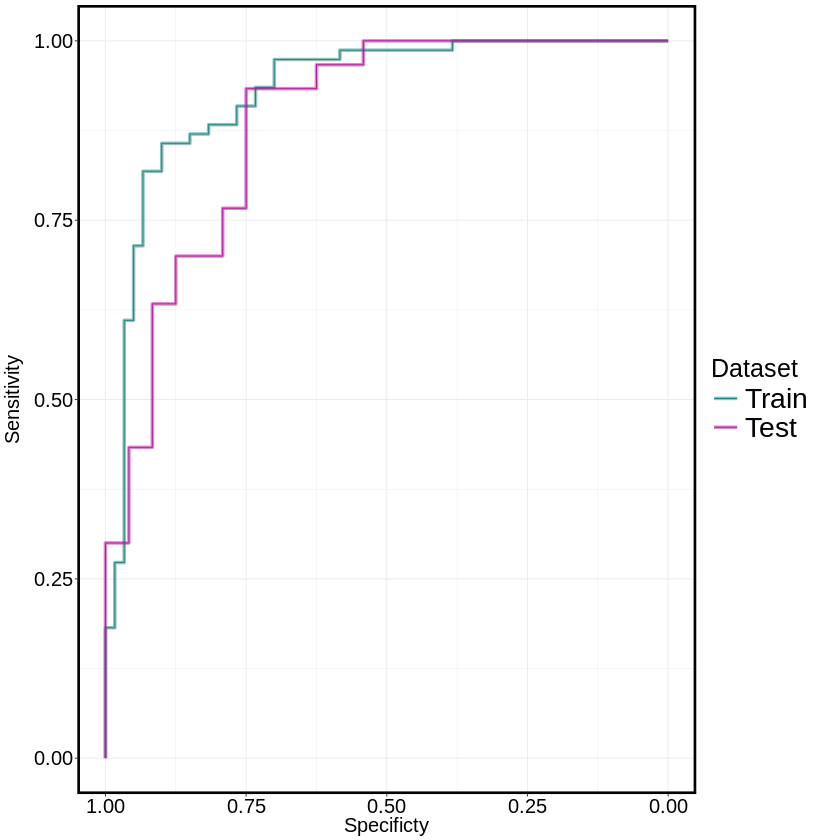

In [ ]:
p = ggroc(list("Train"= roc_train, "Test" = roc_test), aes=c("color"))  +
    theme_bw(base_size=6) +
    geom_line(size=1,alpha=0.5) +
    scale_color_manual(values=c("#218380","#B5179E"), name = "Dataset") +
    xlab("Specificty") + ylab("Sensitivity") +
    theme(axis.text=element_text(size=12, color="black"),
          axis.title=element_text(size=12, color="black"),
          panel.border = element_rect(size = 1.5, color ="black"),
          legend.text = element_text(size = 17),  # Increase legend text size
          legend.title = element_text(size = 15)) # Increase legend title size
p

## Extracting most important features

For Lasso models and linear regression models in general, feature importance is determined by the magnitude of their non-zero coefficients. The Lasso model shrinks the coefficients of less important features to zero, effectively performing feature selection. We can extract these non-zero coefficients to identify the most influential genes in the model's predictions.

In [ ]:
# Extract coefficients from the optimal Lasso model
coefs <- coef(lasso_model$finalModel, lasso_model$bestTune$lambda)

# Convert to a data frame for easier manipulation
feature_importance <- as.data.frame(as.matrix(coefs))

# Rename the coefficient column
colnames(feature_importance) <- "Coefficient"

# Remove the intercept term and any genes with zero coefficients
feature_importance <- feature_importance[-1, , drop = FALSE] # Remove intercept
feature_importance <- feature_importance[feature_importance$Coefficient != 0, , drop = FALSE]

# Get gene IDs as a column
feature_importance$gene_num <- rownames(feature_importance)

# Merge with gene.list to get gene names
# Corrected by.y to 'gene_id' as that is the gene ID column in gene.list
feature_importance <- merge(feature_importance, gene.list, by.x = "gene_num", by.y = "gene_id")

# Sort by absolute coefficient value in descending order
feature_importance <- feature_importance[order(abs(feature_importance$Coefficient), decreasing = TRUE), ]

# Display the top 5 most important features/genes
print("Top 10 Most Important Features (Genes):")
print(head(feature_importance, 5))

[1] "Top 10 Most Important Features (Genes):"
            gene_num Coefficient gene_name      gene_type
5 ENSG00000152818.18  -0.8102607      UTRN protein_coding
6 ENSG00000154451.14   0.7581370      GBP5 protein_coding
2 ENSG00000111669.15   0.2175720      TPI1 protein_coding
7  ENSG00000169564.7   0.1830357     PCBP1 protein_coding
4 ENSG00000136929.13  -0.1416257     HEMGN protein_coding


# Choose a model to improve

Here I provide the basic code to train each of these models. Please look into each of these models and choose your favorite moded. Uncomment the model of your choice and also delete the other models for clarity. Add in a tuneGrid term to the train function to change your hyperparameters.

In [ ]:
#This is the block of code where you will tweak with your model.
### UNIVERSAL CODE FOR ANY MODEL ###
df = norm_plot_dat_train

# Prepare metadata
df$tb <- ifelse(df$tb == "positive", 1, 0)
df$tb <- as.factor(df$tb)

# Extract significant genes
sig_genes_raw <- as.character(sigs$gene_num)

# Use only genes actually in df
available_genes <- colnames(df)
sig_genes <- intersect(sig_genes_raw, available_genes)

# Final dataset for modeling (TB + predictors)
df_model <- df[, c("tb", sig_genes)]

# caret expects factor levels as characters "Negative" and "Positive"
df_model$tb <- factor(df_model$tb, levels = c("0","1"), labels = c("Negative", "Positive"))

############################################################
## GLMNET Ridge (alpha = 0)
############################################################

#my_model <- train(
     #tb ~ .,
     #data = df_model,
     #method = "glmnet",
     #tuneGrid = expand.grid(alpha = 0, lambda = 1)
#)

############################################################
## SVM Linear
############################################################

# install.packages("kernlab")
# library(kernlab)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "svmLinear"
# )


############################################################
## SVM Radial
############################################################

# install.packages("kernlab")
# library(kernlab)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "svmRadial"
# )


############################################################
## Random Forest
############################################################

# install.packages("randomForest")
# library(randomForest)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "rf"
# )


############################################################
## Extra Trees (via ranger with splitrule = extratrees)
############################################################

# install.packages("ranger")
# library(ranger)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "ranger",
#     tuneGrid = expand.grid(
#         mtry = floor(sqrt(ncol(df)-1)),
#         splitrule = "extratrees",
#         min.node.size = 1
#     )
# )


############################################################
## Neural Networks (nnet)
############################################################

# install.packages("nnet")
# library(nnet)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "nnet",
#     trace = FALSE
# )


############################################################
## Linear Discriminant Analysis (LDA)
############################################################

# library(MASS)   # MASS is usually installed with base R

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "lda"
# )


############################################################
## Nearest Shrunken Centroids (PAM)
############################################################

# install.packages("pamr")
# library(pamr)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "pam"
# )


############################################################
## C5.0 Decision Tree
############################################################

# install.packages("C50")
# library(C50)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "C5.0"
# )


############################################################
## K-Nearest Neighbors (KNN)
############################################################

# library(class)   # class is part of base R

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "knn"
# )


############################################################
## Naive Bayes
############################################################

# install.packages("naivebayes")
# library(naivebayes)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "nb"
# )


############################################################
## CART (rpart)
############################################################

# install.packages("rpart")
# library(rpart)

# my_model <- train(
#     tb ~ .,
#     data = df_model,
#     method = "rpart"
# )

In [ ]:
### TRAINING SET, YOUR MODEL ###
# Calculate predictions on training set
probs_train <- predict(my_model, newdata = df_model, type = "prob")

# Assuming 'Positive' is the positive class
roc_train <- roc(df_model$tb, probs_train[["Positive"]])
auc_train <- auc(roc_train)
roc_train_ci = ci.auc(roc_train)
coords_df <- data.frame(coords(roc_train, "all"))

# Calculate the Youden's index for each row
coords_df$youden <- coords_df$sensitivity + coords_df$specificity - 1
# Choose the optimal Youden's index
optimal <- coords_df[which.max(coords_df$youden),]

# Print the AUC value
print(paste0("Training ROC-AUC: ", round(auc(roc_train),3)))
print(paste0("Training ROC-AUC 95% CI: [", round(roc_train_ci[1],3), "--", round(roc_train_ci[3],3), "]"))

# Assign labels using optimal threshold
df_model$predicted <- ifelse(probs_train[["Positive"]] > optimal$threshold, "Positive", "Negative")

# Create Confusion matrix
conf_matrix_train <- table(df_model$tb, df_model$predicted)

# True positive
tp_train <- conf_matrix_train[2, 2]
# True Negative
tn_train <- conf_matrix_train[1, 1]

# Calculate the Accuracy
accuracy_train <- (tp_train + tn_train) / sum(conf_matrix_train)
print(paste("Train Accuracy: ", round(accuracy_train, 3)))

# Calculate the Sensitivity
sensitivity_train <- tp_train / (tp_train + conf_matrix_train[2, 1])
# Calculate the Specificity
specificity_train <- tn_train / (tn_train + conf_matrix_train[1, 2])

### 95% CI for Sensitivity and Specificity ###
# Set z-score for a two tailed 95% confidence test
z <- qnorm(0.975)

# Calculate the number of true positives and true negatives
n_tp <- tp_train + conf_matrix_train[2, 1]  # TP + FN
n_tn <- tn_train + conf_matrix_train[1, 2]  # TN + FP

# Calculate the standard error for sensitivity and specificity
se_sensitivity <- sqrt(sensitivity_train * (1 - sensitivity_train) / n_tp)
se_specificity <- sqrt(specificity_train * (1 - specificity_train) / n_tn)

# Calculate 95% CI for sensitivity
ci_lower_sensitivity <- sensitivity_train - z * se_sensitivity
ci_upper_sensitivity <- sensitivity_train + z * se_sensitivity

# Calculate 95% CI for specificity
ci_lower_specificity <- specificity_train - z * se_specificity
ci_upper_specificity <- specificity_train + z * se_specificity

# Print 95% CI
print(paste("Train Sensitivity: ", round(sensitivity_train, 3)))
print(paste("Train Sensitivity:  95% CI: [", round(ci_lower_sensitivity, 3), ",", round(ci_upper_sensitivity, 4), "]"))
print(paste("Train Specificity: ", round(specificity_train, 3)))
print(paste("Train Specificity:  95% CI: [", round(ci_lower_specificity, 3), ",", round(ci_upper_specificity, 4), "]"))

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



[1] "Training ROC-AUC: 0.928"
[1] "Training ROC-AUC 95% CI: [0.884--0.973]"
[1] "Train Accuracy:  0.876"
[1] "Train Sensitivity:  0.922"
[1] "Train Sensitivity:  95% CI: [ 0.862 , 0.9819 ]"
[1] "Train Specificity:  0.817"
[1] "Train Specificity:  95% CI: [ 0.719 , 0.9146 ]"


In [ ]:
### TEST SET, YOUR MODEL###
df_test = norm_plot_dat_test

# Prepare metadata (tb as factor)
df_test$tb <- ifelse(df_test$tb == "positive",1,0)
df_test$tb <- as.factor(df_test$tb)

# Ensure caret expects factor levels as characters "Negative" and "Positive"
df_test$tb <- factor(df_test$tb, levels = c("0","1"), labels = c("Negative", "Positive"))

# Calculate predictions using the tuned lasso_model
probs_test <- predict(my_model, newdata = df_test, type = "prob")

# Assuming 'Positive' is the positive class
roc_test <- roc(df_test$tb, probs_test[["Positive"]])
roc_test_ci = ci.auc(roc_test)
print(paste0("Test ROC-AUC: ",round(auc(roc_test),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_test_ci[1],3), "--", round(roc_test_ci[3],3), "]"))

# Assign labels using optimal threshold from training
df_test$predicted <- ifelse(probs_test[["Positive"]] > optimal$threshold, "Positive", "Negative")

# Create Confusion matrix
conf_matrix <- table(df_test$tb, df_test$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_test <- (tp + tn) / sum(conf_matrix)
print(paste("Test Accuracy: ", round(accuracy_test, 3)))

# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Test", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Test Sensitivity: ",
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Test", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Test Specificity: ",
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.886"
[1] "Test ROC-AUC 95% CI: [0.788--0.984]"
[1] "Test Accuracy:  0.815"
[1] "Test Sensitivity:  0.733"
[1] "Test Sensitivity:  95% CI: [ 0.556 , 0.858 ]"
[1] "Test Specificity:  0.917"
[1] "Test Specificity:  95% CI: [ 0.742 , 0.977 ]"


# Plot your results for this iteration

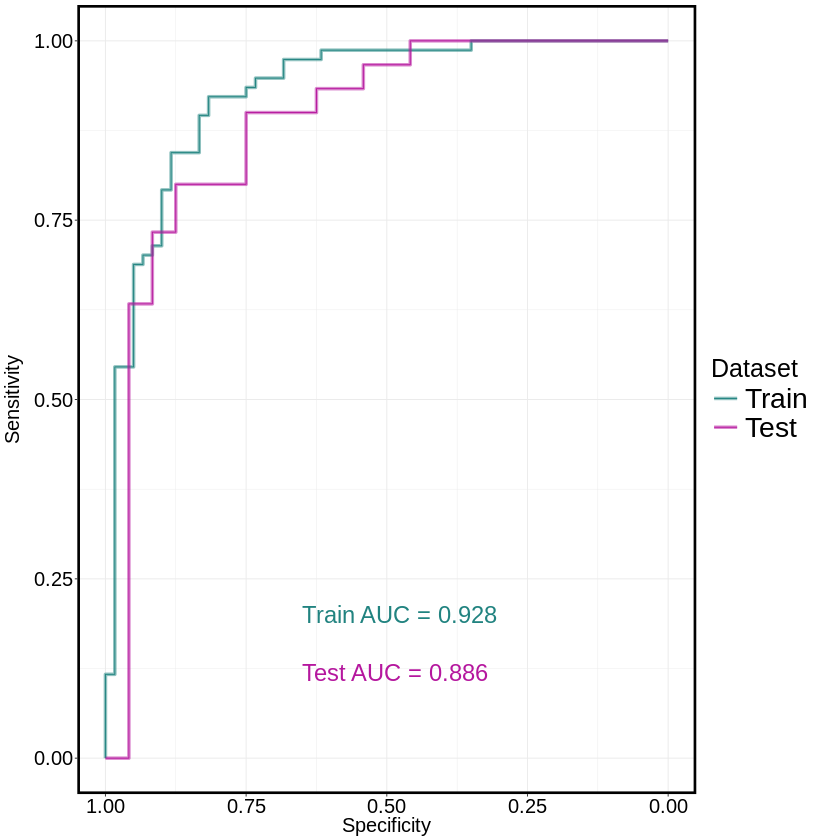

In [ ]:
auc_test <- auc(roc_test)

p <- ggroc(list(Train = roc_train, Test = roc_test)) +
  geom_line(size = 1, alpha = 0.5) +
  theme_bw(base_size = 6) +
  scale_color_manual(values = c(Train = "#218380", Test = "#B5179E"),
                     name = "Dataset") +
  xlab("Specificity") + ylab("Sensitivity") +
  theme(axis.text = element_text(size = 12, color = "black"),
        axis.title = element_text(size = 12, color = "black"),
        panel.border = element_rect(size = 1.5, color = "black"),
        legend.text = element_text(size = 17),
        legend.title = element_text(size = 15)) +

  annotate("text", x = 0.65, y = 0.20,
           label = paste0("Train AUC = ", round(auc(roc_train), 3)),
           color = "#218380", size = 5, hjust = 0) +

  annotate("text", x = 0.65, y = 0.12,
           label = paste0("Test AUC = ", round(auc(roc_test), 3)),
           color = "#B5179E", size = 5, hjust = 0)

p

## Validation of your model

After you have decided on the best version of your model, now you should test how generalizable it is. To do this we will be using our model to predict the TB status of the validation dataset that we created when we first split all of our data.

In [ ]:
df_val = norm_plot_dat_val

# Prepare metadata (tb as factor)
df_val$tb <- ifelse(df_val$tb == "positive",1,0)
df_val$tb <- as.factor(df_val$tb)

# Ensure caret expects factor levels as characters "Negative" and "Positive"
df_val$tb <- factor(df_val$tb, levels = c("0","1"), labels = c("Negative", "Positive"))

# Calculate predictions using the tuned lasso_model
probs_val <- predict(my_model, newdata = df_val, type = "prob")

# Assuming 'Positive' is the positive class
roc_val <- roc(df_val$tb, probs_val[["Positive"]])
roc_val_ci = ci.auc(roc_val)
print(paste0("Test ROC-AUC: ",round(auc(roc_val),3)))
print(paste0("Test ROC-AUC 95% CI: [", round(roc_val_ci[1],3), "--", round(roc_val_ci[3],3), "]"))

# Assign labels using optimal threshold from training
df_val$predicted <- ifelse(probs_val[["Positive"]] > optimal$threshold, "Positive", "Negative")

# Create Confusion matrix
conf_matrix <- table(df_val$tb, df_val$predicted)

# Get all labels for true positive, false positive, etc...
tp <- conf_matrix[2,2]
tn <- conf_matrix[1,1]
fp <- conf_matrix[1,2]
fn <- conf_matrix[2,1]

# Calculate Accuracy
accuracy_val <- (tp + tn) / sum(conf_matrix)
print(paste("Validation Accuracy: ", round(accuracy_val, 3)))

# Calculate Sensitivity and Specificity
sensitivity <- tp / (tp + fn)
specificity <- tn / (tn + fp)

print(paste("Validation", "Sensitivity: ", round(sensitivity, 3)))
sensitivity_ci <- binom.confint(tp, tp + fn, conf.level = 0.95, methods = "wilson")
print(paste("Validation Sensitivity: ",
            "95% CI: [", round(sensitivity_ci$lower, 3), ",", round(sensitivity_ci$upper, 3), "]"))

# Calculate 95% CI for specificity
print(paste("Validation", "Specificity: ", round(specificity, 3)))
specificity_ci <- binom.confint(tn, tn + fp, conf.level = 0.95, methods = "wilson")
print(paste("Validation Specificity: ",
            "95% CI: [", round(specificity_ci$lower, 3), ",", round(specificity_ci$upper, 3), "]"))

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases



[1] "Test ROC-AUC: 0.838"
[1] "Test ROC-AUC 95% CI: [0.723--0.953]"
[1] "Validation Accuracy:  0.783"
[1] "Validation Sensitivity:  0.829"
[1] "Validation Sensitivity:  95% CI: [ 0.673 , 0.919 ]"
[1] "Validation Specificity:  0.72"
[1] "Validation Specificity:  95% CI: [ 0.524 , 0.857 ]"


## Plot the final results

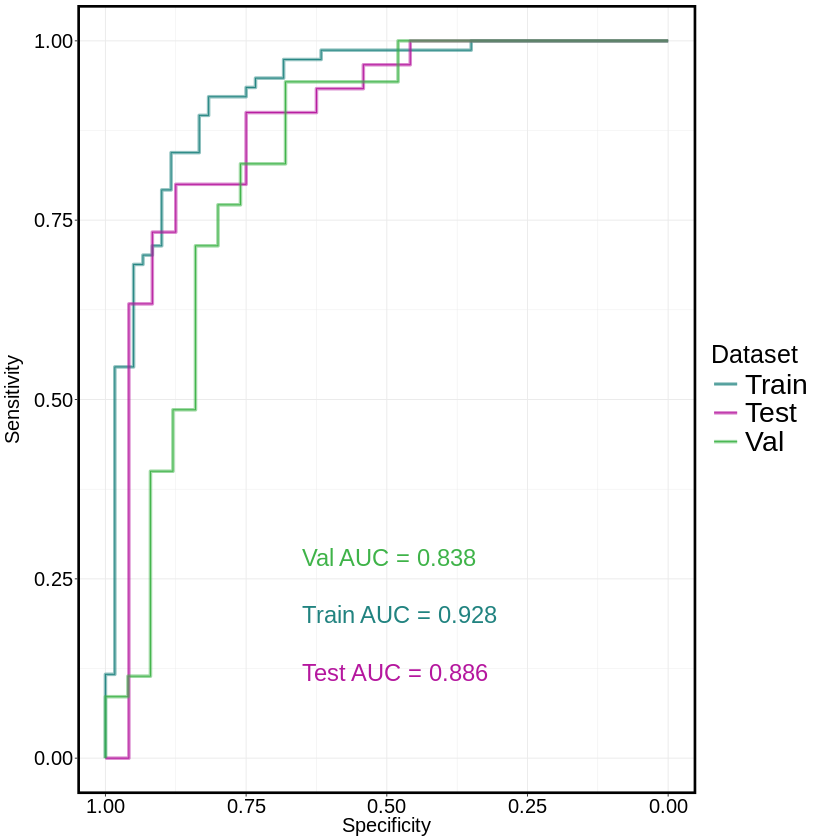

In [ ]:
auc_test <- auc(roc_test)
auc_val  <- auc(roc_val)

p <- ggroc(list(Train = roc_train, Test = roc_test, Val = roc_val)) +
  geom_line(size = 1, alpha = 0.5) +
  theme_bw(base_size = 6) +
  scale_color_manual(values = c(Train = "#218380", Test = "#B5179E",Val = "#3FB349"),
                     name = "Dataset") +
  xlab("Specificity") + ylab("Sensitivity") +
  theme(axis.text = element_text(size = 12, color = "black"),
        axis.title = element_text(size = 12, color = "black"),
        panel.border = element_rect(size = 1.5, color = "black"),
        legend.text = element_text(size = 17),
        legend.title = element_text(size = 15)) +

  annotate("text", x = 0.65, y = 0.28,
           label = paste0("Val AUC = ", round(auc_val, 3)),
           color = "#3FB349", size = 5, hjust = 0) +

  annotate("text", x = 0.65, y = 0.20,
           label = paste0("Train AUC = ", round(auc(roc_train), 3)),
           color = "#218380", size = 5, hjust = 0) +

  annotate("text", x = 0.65, y = 0.12,
           label = paste0("Test AUC = ", round(auc(roc_test), 3)),
           color = "#B5179E", size = 5, hjust = 0)

p